In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/TCC/dataset.zip

In [4]:
!ls dataset

benign	malignant


In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds.class_names

Found 19084 files belonging to 2 classes.
Using 15268 files for training.
Found 19084 files belonging to 2 classes.
Using 3816 files for validation.


['benign', 'malignant']

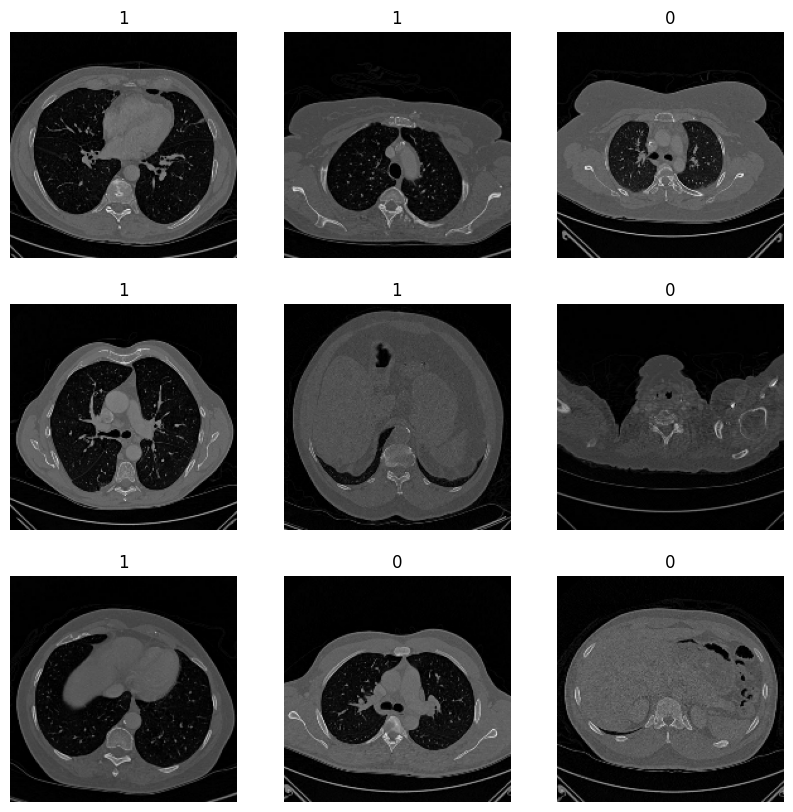

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

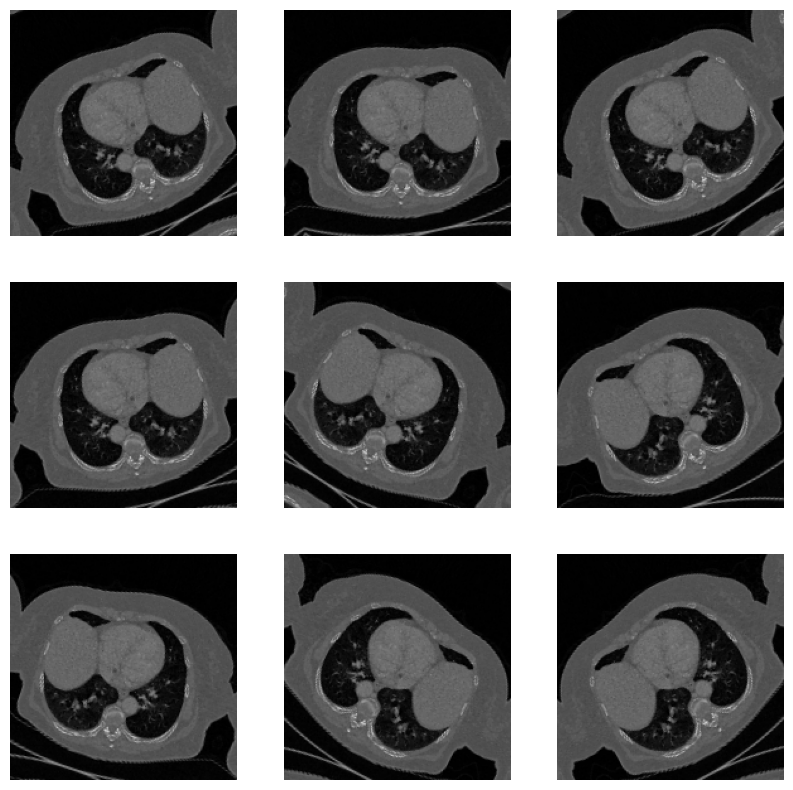

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
input_shape = (50,50,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

Ellipsis

In [10]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

94765736/94765736 [==============================] - 0s 0us/step


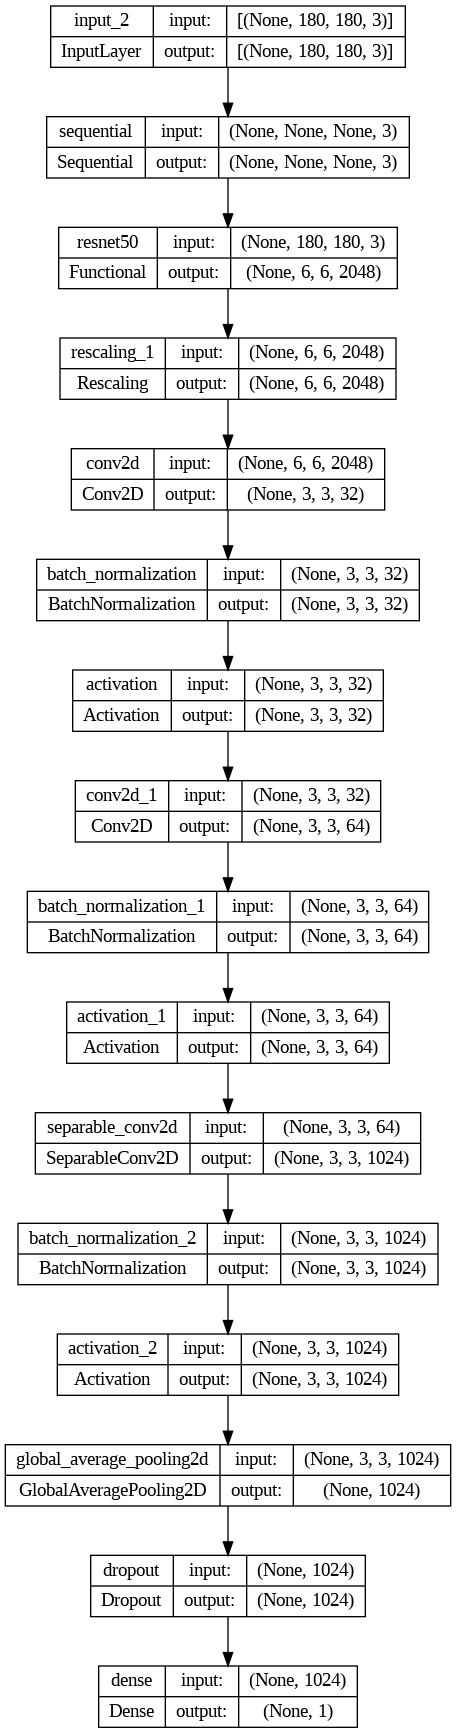

In [12]:
from keras.applications import ResNet50

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model(x)

    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs, name='resnet50')

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 50

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
478/478 [==============================] - 185s 275ms/step - loss: 0.6158 - accuracy: 0.6486 - val_loss: 0.6249 - val_accuracy: 0.6177
Epoch 2/50
478/478 [==============================] - 130s 271ms/step - loss: 0.4467 - accuracy: 0.7809 - val_loss: 1.5283 - val_accuracy: 0.6468
Epoch 3/50
478/478 [==============================] - 131s 273ms/step - loss: 0.3253 - accuracy: 0.8596 - val_loss: 0.7281 - val_accuracy: 0.7353
Epoch 4/50
478/478 [==============================] - 131s 274ms/step - loss: 0.2345 - accuracy: 0.9035 - val_loss: 0.5513 - val_accuracy: 0.7738
Epoch 5/50
478/478 [==============================] - 132s 274ms/step - loss: 0.1646 - accuracy: 0.9364 - val_loss: 0.9734 - val_accuracy: 0.7372
Epoch 6/50
478/478 [==============================] - 132s 276ms/step - loss: 0.1378 - accuracy: 0.9473 - val_loss: 0.3544 - val_accuracy: 0.8776
Epoch 7/50
478/478 [==============================] - 130s 272ms/step - loss: 0.0925 - accuracy: 0.9648 - val_loss: 0.1979 -

In [14]:
def classify_image(image_path):
  img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = predictions[0]
  benign = 100 * (1 - score)
  malignant = 100 * score
  print("This image is %.2f%% benign and %.2f%% malignant." % (benign, malignant))

In [15]:
image_path = "dataset/benign/011-001.jpg"

classify_image(image_path)

1/1 [==============================] - 2s 2s/step
This image is 100.00% benign and 0.00% malignant.


In [16]:
image_path = "dataset/malignant/011-006.jpg"

classify_image(image_path)

1/1 [==============================] - 0s 40ms/step
This image is 0.00% benign and 100.00% malignant.
